<a href="https://colab.research.google.com/github/lofrienger/OneToMany_ToolSynSeg/blob/main/demo/colab/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download repo:

In [1]:
!git clone https://github.com/lofrienger/OneToMany_ToolSynSeg.git

Cloning into 'OneToMany_ToolSynSeg'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 152 (delta 22), reused 135 (delta 13), pack-reused 0
Receiving objects: 100% (152/152), 31.32 MiB | 21.73 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [2]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import imgaug.augmenters as iaa

Define augmentation for fg

In [3]:
# define augmentations
def sometimes_1(aug): return iaa.Sometimes(0.6, aug)
def sometimes_2(aug): return iaa.Sometimes(0.2, aug)
def sometimes_3(aug): return iaa.Sometimes(0.4, aug)
augseq = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontally flip 50% of all images
    iaa.Flipud(0.2),  # vertically flip 20% of all images
    sometimes_2(iaa.Crop(px=(10, 200))),
    sometimes_2(iaa.PerspectiveTransform(scale=(0.1, 0.2))), # +
    sometimes_1(iaa.Affine(
        # scale images to 80-120% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -20 to +20 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-45, 45),  # rotate by -45 to +45 degrees
        # shear=(-16, 16), # shear by -16 to +16 degrees
        order=[0, 1],  # use nearest neighbour or bilinear interpolation (fast)
        # cval=(0, 255), # if mode is constant, use a cval between 0 and 255
        cval=0,
        # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        mode='constant'
    )),
    sometimes_3(iaa.OneOf([
        # blur images with a sigma between 0 and 3.0
        iaa.GaussianBlur((0, 3.0)),
        # blur image using local means with kernel sizes between 2 and 7
        iaa.AverageBlur(k=(2, 7)),
        # blur image using local medians with kernel sizes between 3 and 11
        iaa.MedianBlur(k=(3, 11)),
    ])),
],random_order=True)

Extract fg tool with mask and apply augmentations

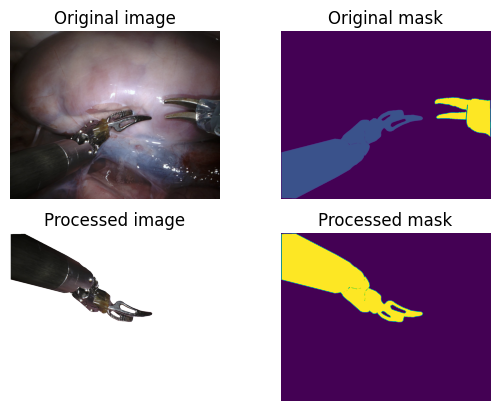

In [4]:
# take bipolar forceps (class id: 1) as an example
fg_root = '/content/OneToMany_ToolSynSeg/data_gen/srcdata/fg/endovis18/source/1-Bipolar_Forceps/'
file_name = 'seq_10_frame017.png'
class_id = 1

image_dir = os.path.join(fg_root, 'image_3', file_name)
image_ori = Image.open(image_dir)
images = np.expand_dims(np.array(image_ori, dtype=np.uint8), axis=0)

mask_dir = os.path.join(fg_root, 'mask', file_name)
mask_ori = np.array(Image.open(mask_dir))
mask_pos = np.copy(mask_ori)
mask_pos[mask_pos!=class_id] = 0
segmaps = np.expand_dims(mask_pos, axis=(0, 3))

# Augmentation
images_aug, segmaps_aug = augseq(images=images, segmentation_maps=segmaps)
image_aug = np.squeeze(images_aug)
segmap_aug = np.squeeze(segmaps_aug).astype('uint8')

image_pil = Image.fromarray(image_aug).convert('RGBA')
mask_pil = Image.fromarray(segmap_aug).convert('RGBA')

image_np = np.array(image_pil)
mask_np = np.array(mask_pil)

image_np[mask_np[:,:,:]==0] = 255
image_pos = Image.fromarray(image_np)
datas = image_pos.getdata()
newData = []
for items in datas:
    if items[0] == 255 and items[1] == 255 and items[2] == 255:
        newData.append((255, 255, 255, 0))
    else:
        newData.append(items)
image_pos.putdata(newData)

# plt.figure(figsize=(10,12))
plt.subplot(221)
plt.axis('off')
plt.title('Original image')
plt.imshow(image_ori)
plt.subplot(222)
plt.axis('off')
plt.title('Original mask')
plt.imshow(mask_ori)
plt.subplot(223)
plt.axis('off')
plt.title('Processed image')
plt.imshow(image_pos)
plt.subplot(224)
plt.axis('off')
plt.title('Processed mask')
plt.imshow(segmap_aug)

Define augmentation for bg

In [5]:
# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
def sometimes_1(aug): return iaa.Sometimes(0.3, aug)
def sometimes_2(aug): return iaa.Sometimes(0.3, aug)
def sometimes_3(aug): return iaa.Sometimes(0.15, aug)
# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.

bgaugseq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5),  # horizontally flip 50% of all images
        iaa.Flipud(0.2),  # vertically flip 20% of all images
        sometimes_2(iaa.Crop(percent=(0.05, 0.5), keep_size=True)),
        # change brightness of images (by -10 to 10 of original value)
        sometimes_2(iaa.Add((-40, 40), per_channel=0.5)),
        # change hue and saturation
        sometimes_2(iaa.AddToHueAndSaturation((-20, 20))),
        # either change the brightness of the whole image (sometimes
        # per channel) or change the brightness of subareas
        sometimes_2(iaa.OneOf([
            iaa.Multiply((0.5, 1.5), per_channel=0.5),
            iaa.FrequencyNoiseAlpha(
                exponent=(-4, 0),
                first=iaa.Multiply((0.5, 1.5), per_channel=True),
                second=iaa.LinearContrast((0.5, 2.0))
            )
        ])),
        # improve or worsen the contrast
        sometimes_2(iaa.LinearContrast((0.5, 2.0), per_channel=0.5)),
        sometimes_2(iaa.PerspectiveTransform(
            scale=(0.1, 0.2), keep_size=True)),
        sometimes_3(iaa.Cutout(fill_mode="gaussian", fill_per_channel=True)),
        # crop images by -5% to 10% of their height/width
        sometimes_1(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode='reflect',
            pad_cval=(0, 255), keep_size=True
        )),
        sometimes_1(iaa.Affine(
            # scale images to 80-120% of their size, individually per axis
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            # translate by -20 to +20 percent (per axis)
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),  # rotate by -45 to +45 degrees
            shear=(-20, 20),  # shear by -16 to +16 degrees
            # use nearest neighbour or bilinear interpolation (fast)
            order=[0, 1],
            cval=(0, 255),  # if mode is constant, use a cval between 0 and 255
            # cval=0,
            # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            mode='reflect'
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 2),
                   [
            # sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
            iaa.OneOf([
                # blur images with a sigma between 0 and 3.0
                iaa.GaussianBlur((0, 3.0)),
                # blur image using local means with kernel sizes between 2 and 7
                iaa.AverageBlur(k=(2, 7)),
                # blur image using local medians with kernel sizes between 2 and 7
                iaa.MedianBlur(k=(3, 11)),
            ]),
            iaa.Sharpen(alpha=(0, 1.0), lightness=(
                0.75, 1.5)),  # sharpen images
            iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),  # emboss images
            # search either for all edges or for directed edges,
            # blend the result with the original image using a blobby mask
            iaa.SimplexNoiseAlpha(iaa.OneOf([
                iaa.EdgeDetect(alpha=(0, 0.5)),
                iaa.DirectedEdgeDetect(
                    alpha=(0, 0.5), direction=(0.0, 1.0)),
            ])),
            # add gaussian noise to images
            iaa.AdditiveGaussianNoise(loc=0, scale=(
                0.0, 0.05*255), per_channel=0.5),
            iaa.OneOf([
                # randomly remove up to 10% of the pixels
                iaa.Dropout((0.01, 0.1), per_channel=0.5),
                iaa.CoarseDropout((0.03, 0.15), size_percent=(
                    0.02, 0.05), per_channel=0.2),
            ]),
        ],
            random_order=True
        )
    ],
    random_order=True
)

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


Apply augmentation on bg

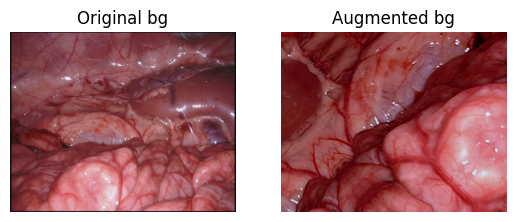

In [14]:
bg_path = '/content/OneToMany_ToolSynSeg/data_gen/srcdata/bg/source/3-frame020.png'
bg_ori = np.array(Image.open(bg_path))
bgs = np.expand_dims(bg_ori, axis=0)
bgs_aug = bgaugseq(images=bgs)
bg_pos = np.squeeze(bgs_aug)

plt.subplot(121)
plt.axis('off')
plt.title('Original bg')
plt.imshow(bg_ori)
plt.subplot(122)
plt.axis('off')
plt.title('Augmented bg')
plt.imshow(bg_pos)

Blend processed fg onto bg

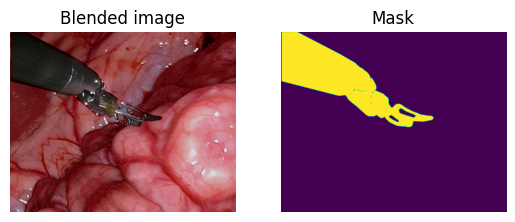

In [16]:
import sys
sys.path.append('/content/OneToMany_ToolSynSeg/data_gen/')

from blending import *
blend_options = ['alpha', 'gaussian', 'laplacian'] # candidate blending options
mask = np.copy(segmap_aug)
mask[mask!=0]=255
blended = blend(np.array(image_pos.convert('RGB')), mask, bg_pos, 512, 640, blend_options[2])

plt.subplot(121)
plt.axis('off')
plt.title('Blended image')
plt.imshow(blended)
plt.subplot(122)
plt.axis('off')
plt.title('Mask')
plt.imshow(mask)